### Transfer Learning
It is not easy to generate high quality benchmarking dataset in the biomedical natural language processing domain. The primary reasons are the requirement of domain-knowledge and economics cost. Exploring the known entity in a new corpus would increase the data used for learning, which ultimately increased the performance of a model. To achieve the goal,  I asked a question - does entity can be quantified for learning?

Three input data are required.  
1. NCBI_UniquePubmedID.txt/NCBI_corpus_gs.out
2. CDR_UniquePubmedID.txt/CDR_gs.out
3. [disease2pubtatorcentral](https://www.ncbi.nlm.nih.gov/research/pubtator/)

The files mentioned in first and second should generate using the [program](https://github.com/exchhattu/BiomedicaLorHealthCare-NLP) 

In [1]:
import numpy as np

In [2]:
def get_gs_pubmedids(path_to_file=""):
  with open(path_to_file, "r") as fo_read:
    ts_readlines = fo_read.read().split("\n")
  return ts_readlines

In [3]:
ncbi_pubs = get_gs_pubmedids("./data/NCBI_disease_corpus/NCBI_UniquePubmedID.txt")
cdr_pubs = get_gs_pubmedids("./data/CDR/CDR_UniquePubmedID.txt")

In [4]:
def select_pubmedids_randomly(path_to_file, ts_unique_gs_pubmed_ids = ncbi_pubs + cdr_pubs):
  # ma_diseases = {}
  ma_diseases_count = {}
  # get random numbers  
  np.random.seed(6)
  ar_choices = np.sort(np.random.choice(range(35000000), 20000000, replace=False))
 
  in_line_count    = -1
  in_ar_idx        = 0
  in_unique_pubmed = 0
  with open(path_to_file, "r") as fo_read:
    # select either 50000 non repetitive pubmeds 
    while in_unique_pubmed < 50000 and in_ar_idx < ar_choices.shape[0]:
      st_line = fo_read.readline().split("\n")[0]
      in_line_count += 1
      if in_line_count < ar_choices[in_ar_idx]:
        continue
      elif in_line_count == ar_choices[in_ar_idx]:
        st_parts = st_line.split("\t")
        #print("if ", in_line_count, st_parts, ar_choices[in_ar_idx])
        st_pubmed_id = st_parts[0]
        if not st_parts[-1] == "TaggerOne": continue
        if not st_pubmed_id in ts_unique_gs_pubmed_ids:
          # print("if12 ", in_line_count, st_parts, ar_choices[in_ar_idx])
          st_did = st_parts[2].replace("MESH:","")
          # ma_diseases[st_did] = ma_diseases.get(st_did, [])
          # ma_diseases[st_did].append(st_parts[3])
          
          ma_diseases_count[st_did] = ma_diseases_count.get(st_did, 0) + 1
          
      in_ar_idx += 1
  # return ma_diseases.copy(), ma_diseases_count.copy()
  return ma_diseases_count.copy()
      

In [5]:
ma_diseases_count = select_pubmedids_randomly("./data/pubtator/disease2pubtatorcentral") #disease2pubtatorcentral1000.dat")

In [6]:
# Disease entity identified in manually curated from two different corpus 

di_gs_count = {}
def parse_gs_dner_dcount(path_to_file):
  ts_unique_diseases = []
  with open(path_to_file, "r") as fo_read:
    ts_lines = fo_read.read().split("\n")
    for st_line in ts_lines:
      if st_line.startswith("UniqueDiseaseCount:"):
        # only first two columns are required
        ts_columns = st_line.replace("UniqueDiseaseCount: ", "").split(",")
        di_gs_count[ts_columns[0]] = di_gs_count.get(ts_columns[0], 0) + int(ts_columns[1])

parse_gs_dner_dcount("./data/NCBI_disease_corpus/NCBI_corpus_gs.out")
parse_gs_dner_dcount("./data/CDR/CDR_gs.out")

# Quantify the entity from secondary data source for which mutually exclusive 
# 50K research articles were randomly selected. Afterward, log ratio of entity 
# between two source was taken, which indicates the changes in fold.
di_logratio = {}
di_gs_updated = {}
for st_gs_key in di_gs_count.keys():
  if st_gs_key in ma_diseases_count.keys():
    di_logratio[st_gs_key] = np.log10(ma_diseases_count[st_gs_key]) - np.log10(di_gs_count[st_gs_key])
    di_gs_updated[st_gs_key] = di_gs_count[st_gs_key]

X = np.zeros(len(di_gs_updated))
Y = np.zeros(len(di_gs_updated))

i = 0
for st_key in di_logratio.keys():
  X[i]= di_gs_updated[st_key]
  Y[i]= di_logratio[st_key]
  i += 1

In [7]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import seaborn as sns

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

font      = {'family':'arial', 'style':'normal', 'size':18}
axis_font = {'family':'arial', 'style':'normal', 'size':18}
plt.rc('font', **font)

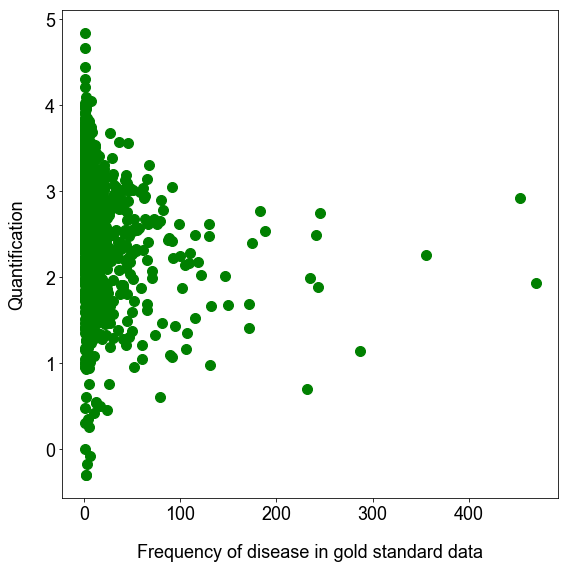

In [8]:
fig  = plt.figure(figsize=(8, 8))
ax   = fig.add_subplot(111)
ax.scatter(X, Y, s=100, color='green', edgecolor="green")
ax.tick_params(axis="both", labelsize=18)
ax.set_xlabel("Frequency of disease in gold standard data", axis_font, labelpad=20)
ax.set_ylabel("Quantification", axis_font, labelpad=20)
plt.tight_layout()
plt.show()

This approach allows learning from more data to develop a model. Interestingly, the least quantified entities were increased at most as shown in the graph above. This not only increases the entity but provides the diverse contexts of the entity. This is useful for developing deep neural network model.  